In [61]:
from activation_funcs import *

In [62]:
# ================================================================
# SymPy implementation of central-idempotent projectors
# for the k-subset representation of S_n (two-row partitions only)
# Now with Fourier-basis transforms + blockwise nonlinear interface
# ================================================================
import itertools as it
import math
from collections import Counter
from sympy import Matrix, Rational, eye, sqrt, symbols, expand


# -----------------------------------
# Exact Gram–Schmidt implementation
# -----------------------------------
def gram_schmidt(vectors, orthonormal=False):
    """
    Simple exact Gram–Schmidt process for SymPy column vectors.
    vectors: list of sympy.Matrix column vectors
    orthonormal: if True, normalizes each output vector to unit norm
    """
    ortho = []
    for v in vectors:
        w = v
        for u in ortho:
            w = w - (u.dot(v) / u.dot(u)) * u
        if w.norm() == 0:
            continue
        if orthonormal:
            w = w / sqrt(w.dot(w))
        ortho.append(w)
    return ortho

# -----------------------------------
# Combinatorial helpers
# -----------------------------------

def dim_two_row(n, i):
    """
    dim S^{(n-i,i)} = C(n,i) - C(n,i-1).
    This is the rank of the block for the irrep (n-i,i).
    """
    return math.comb(n, i) - (math.comb(n, i-1) if i > 0 else 0)

def all_perms(n):
    """All permutations of {0,...,n-1} as tuples."""
    return list(it.permutations(range(n)))

def cycle_type(p):
    """
    Return the cycle type of permutation p as a partition tuple.
    Example: (0 1)(2)(3 4 5) -> (3,2,1).
    """
    n = len(p)
    seen = [False]*n
    cyc = []
    for i in range(n):
        if not seen[i]:
            j=i; L=0
            while not seen[j]:
                seen[j] = True
                j = p[j]
                L += 1
            cyc.append(L)
    cyc.sort(reverse=True)
    return tuple(cyc)

def conjugacy_classes_with_members(n):
    """
    Return list of conjugacy classes of S_n, each as:
    {
        "type": cycle type (like (2,2,1,...)),
        "size": class size,
        "members": [permutations g in that class]
    }
    We'll brute-force because n is small.
    """
    classes = {}
    for g in all_perms(n):
        mu = cycle_type(g)
        classes.setdefault(mu, []).append(g)
    out = []
    for mu, members in classes.items():
        out.append({"type": mu, "size": len(members), "members": members})
    return out

# -----------------------------------
# k-subset permutation representation  ρ : S_n -> GL(R[X_k])
# -----------------------------------

def k_subsets(n, k):
    """
    Return list of all k-subsets of {0,...,n-1} as sorted tuples.
    This is our 'pixel basis' / original coordinate system.
    """
    return [tuple(c) for c in it.combinations(range(n), k)]

def rho_matrix(n, k, sigma):
    """
    Permutation matrix ρ(sigma) on the basis {e_A}_{A in X_k}.
    Each basis vector e_A gets sent to e_{sigma(A)}.
    """
    Xk = k_subsets(n, k)
    idx = {A:i for i,A in enumerate(Xk)}
    m = len(Xk)
    M = [[0]*m for _ in range(m)]
    for j,A in enumerate(Xk):
        B = tuple(sorted(sigma[a] for a in A))
        i = idx[B]
        M[i][j] = 1
    return Matrix(M)

# -----------------------------------
# Two-row character polynomials
# -----------------------------------

def chi_two_row(n, i, cycle_type_part):
    """
    χ^{(n-i,i)}(σ) = π_{n,i}(σ) - π_{n,i-1}(σ)
    where π_{n,k}(σ) = [x^k] ∏_{m>=1} (1+x^m)^{a_m}.
    """
    x = symbols('x')
    c = Counter(cycle_type_part)
    a = {m: c.get(m,0) for m in range(1, n+1)}  # counts of m-cycles

    def pi(n, k):
        # product_(m=1)^n (1+x^m)^{a_m}
        P = 1
        for m, am in a.items():
            if am > 0:
                P *= (1 + x**m)**am
        P = expand(P)
        coeff = P.expand().coeff(x, k)
        return coeff

    if i == 0:
        return 1
    else:
        return pi(n, i) - pi(n, i-1)


# -----------------------------------
# Central idempotent projectors p_{(n-i,i)}
# -----------------------------------

def projectors_two_row_vnk(n, k):
    """
    Construct:
    - proj[i] = projector p_{(n-i,i)} in the original (k-subset) basis.
      This is an S_n-equivariant idempotent of rank dim_two_row(n,i).
    - Qblocks[i] = an ONB (orthonormal basis) for im(proj[i]).
      Columns of Qblocks[i] span that irreducible subspace.

    We also return 'basis' = list of k-subsets, i.e. the coordinate labels.
    """
    basis = k_subsets(n, k)
    m = len(basis)
    classes = conjugacy_classes_with_members(n)

    # cache ρ(g) for all permutations we'll touch
    rho = {}
    for C in classes:
        for g in C["members"]:
            if g not in rho:
                rho[g] = rho_matrix(n, k, g)

    proj = {}
    Qblocks = {}
    for i in range(0, k+1):
        dimL = dim_two_row(n, i)

        # M = Σ_{classes C} χ^{(n-i,i)}(C) * (Σ_{g∈C} ρ(g))
        M = Matrix.zeros(m)
        for C in classes:
            mu = C["type"]
            chi_val = chi_two_row(n, i, mu)

            # true class sum S_C = Σ_{g in class C} ρ(g)
            S_C = sum((rho[g] for g in C["members"]), Matrix.zeros(m))

            M += chi_val * S_C

        # central idempotent formula:
        # p_λ = (dim λ / |S_n|) * M
        p = Rational(dimL, math.factorial(n)) * M

        # numerically enforce symmetry (p should be symmetric in this real rep)
        p = (p + p.T) / 2
        proj[i] = p

        # find eigenvectors with eigenvalue 1 (the image of the projector)
        evects = p.eigenvects()

        eig1 = [v for (val, mult, vecs) in evects if val == 1 for v in vecs]
        if len(eig1) < dimL:
            # fallback tolerance in case SymPy gives val=1 as Rational(1) vs Float
            eig1 += [
                v for (val, mult, vecs) in evects
                if abs(float(val) - 1) < 1e-8
                for v in vecs
            ]

        cols = [Matrix(v) for v in eig1[:dimL]]

        # exact Gram–Schmidt to get orthonormal columns
        ortho_cols = gram_schmidt(cols, orthonormal=True)
        Qblocks[i] = Matrix.hstack(*ortho_cols)

    return proj, Qblocks, basis

# -----------------------------------
# Fourier basis utilities
# -----------------------------------

def assemble_Q(Qblocks):
    """
    Stack the ONBs from each irreducible subspace into one big square matrix Q.
    Columns of Q form an orthonormal basis of the whole space, block-ordered
    by irreps (n-i,i), i=0..k.
    """
    return Matrix.hstack(*[Qblocks[i] for i in sorted(Qblocks.keys())])

def block_sizes_from_Qblocks(Qblocks):
    """
    Return list of block sizes [dim S^{(n-0,0)}, dim S^{(n-1,1)}, ...]
    in the same sorted order.
    """
    sizes = []
    for i in sorted(Qblocks.keys()):
        sizes.append(Qblocks[i].shape[1])
    return sizes

def to_fourier(Q, v):
    """
    Fourier transform: go from "physical" / subset basis coords v (length = C(n,k))
    to irrep-block coordinates v_hat.
    v_hat = Q^T v because Q is orthonormal.
    """
    return Q.T * v

def from_fourier(Q, v_hat):
    """
    Inverse Fourier transform.
    v = Q v_hat.
    """
    return Q * v_hat

def split_fourier_blocks(v_hat, block_sizes):
    """
    Take a stacked vector in Fourier space and slice it into irreducible pieces.
    Returns a list [block0, block1, ...] where block_i lives in irrep (n-i,i).
    """
    blocks = []
    start = 0
    for sz in block_sizes:
        blocks.append(v_hat[start:start+sz, :])
        start += sz
    return blocks

def merge_fourier_blocks(block_list):
    """
    Inverse of split_fourier_blocks: vertical stack.
    """
    return Matrix.vstack(*block_list)

def nonlinear_fourier_update(v_hat, block_sizes, blockwise_funcs):
    """
    Apply user-specified nonlinearities in Fourier space, block by block.

    blockwise_funcs is a dict i -> function
      where i indexes the irreducible (n-i,i).
      Each function takes a block (Matrix of shape [dim_i, 1] or [dim_i, batch])
      and returns a same-shape Matrix.

    If some i is missing in blockwise_funcs, we leave that block unchanged.

    This is the hook to put in activations that respect equivariance structure.
    """
    blocks = split_fourier_blocks(v_hat, block_sizes)
    new_blocks = []
    for i, block in enumerate(blocks):
        if i in blockwise_funcs:
            new_blocks.append(blockwise_funcs[i](block))
        else:
            new_blocks.append(block)
    return merge_fourier_blocks(new_blocks)

# -----------------------------------
# Verification & block diagonalization
# -----------------------------------

def verify_projectors(proj, dims):
    """
    Check:
    - p_i^2 = p_i
    - trace(p_i) = dim block
    - p_i p_j = 0 for i != j
    - sum_i p_i = I
    """
    ok = True
    keys = sorted(proj.keys())
    m = proj[keys[0]].rows
    I = eye(m)

    for i in keys:
        if not (proj[i]*proj[i]).equals(proj[i]):
            print(f"[warn] Projector {i} not idempotent."); ok=False
        tr = proj[i].trace()
        if tr != dims[i]:
            print(f"[warn] trace(p_{i})={tr} differs from dim {dims[i]}."); ok=False

    S = sum((proj[i] for i in keys), Matrix.zeros(m))
    if not S.equals(I):
        print("[warn] Sum of projectors not identity."); ok=False

    for a in keys:
        for b in keys:
            if a < b and not (proj[a]*proj[b]).is_zero_matrix:
                print(f"[warn] Projectors {a},{b} not orthogonal."); ok=False
    return ok

def block_diagonalize(n, k, Q, sigma):
    """
    Compute Q^T ρ(sigma) Q.
    This should be block-diagonal (one block per irrep).
    """
    R = rho_matrix(n, k, sigma)
    return (Q.T * R * Q).applyfunc(lambda x: x.simplify())

Irrep nodes present (i indexes (n-i,i)):
i=0, shape=(n-0,0), dim=1, source k=0
i=1, shape=(n-1,1), dim=7, source k=1
i=2, shape=(n-2,2), dim=20, source k=2

Edges i -> j detected under ReLU:
(n-0,0) -> (n-0,0) via carrier k=0
(n-1,1) -> (n-1,1) via carrier k=1
(n-2,2) -> (n-2,2) via carrier k=2


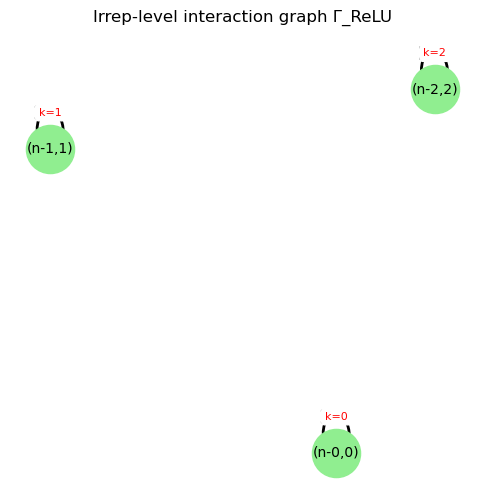

In [64]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from sympy import Matrix

# -------------------------------------------------
# Helper: build decompositions for k = 0..K_max
# -------------------------------------------------

def build_decompositions(n, K_max):
    """
    For each k, run projectors_two_row_vnk(n,k) to get Qblocks etc.
    Return:
      decomps[k] = {
        "Qblocks": {i: Q_{k,i}},
        "basis": basis_k
      }
    """
    decomps = {}
    for k in range(0, K_max+1):
        proj, Qblocks, basis = projectors_two_row_vnk(n, k)
        decomps[k] = {
            "Qblocks": Qblocks,
            "basis": basis
        }
    return decomps

# -------------------------------------------------
# Step 1. Canonicalize irreps L_i
# -------------------------------------------------

def canonical_irrep_blocks(decomps):
    """
    Pick one representative carrier space for each irrep index i.

    Output:
      irreps[i] = {
         "Q": Q_i,          # columns span L_i inside some V_{n,k_i}
         "k_source": k_i,   # which k we stole it from
         "dim": Q_i.shape[1],
         "ambient_dim": Q_i.shape[0],
      }

    Note: we assume multiplicity 1 for two-row irreps, which is true in V_{n,k}.
    """
    irreps = {}
    for k, data in decomps.items():
        for i, Qki in data["Qblocks"].items():
            if i not in irreps:
                irreps[i] = {
                    "Q": Qki,
                    "k_source": k,
                    "dim": Qki.shape[1],
                    "ambient_dim": Qki.shape[0],
                }
    return irreps

# -------------------------------------------------
# Step 2. Define activation in ambient coordinates
# -------------------------------------------------

def relu_on_coords(vec, func=RELU):
    """
    Apply ReLU coordinatewise to a column vector (SymPy Matrix).
    Return new SymPy Matrix of same shape.
    """
    return vec.applyfunc(func)

# -------------------------------------------------
# Step 3. Probe interaction L_i -> L_j under ReLU
# -------------------------------------------------

def test_edge_relu(irreps, i, j, num_samples=5, tol=1e-10):
    """
    Check if there is a nonzero piecewise-linear map from L_i to L_j
    induced by:
        L_i --(embed via Q_i)--> ambient
            --ReLU coordwise--> ambient
            --(project via Q_j^T)--> L_j.

    We do this by random sampling: pick random coeffs in L_i, push through,
    and see if we ever land nontrivially in L_j.

    Returns True if we detect a nonzero interaction.
    """
    Qi = irreps[i]["Q"]  # ambient_dim x dim_i
    Qj = irreps[j]["Q"]  # ambient_dim x dim_j

    ambient_dim = Qi.shape[0]
    assert ambient_dim == Qj.shape[0], \
        "Different ambient dims: you chose different carriers for i,j."

    dim_i = Qi.shape[1]
    for _ in range(num_samples):
        # random integer coeffs for stability
        coeffs_i = Matrix([random.randint(-2, 2) for _ in range(dim_i)])
        v_in_ambient = Qi * coeffs_i          # embed into carrier
        v_after_relu = relu_on_coords(v_in_ambient)
        coeffs_j = Qj.T * v_after_relu        # project to irrep j

        if any(abs(float(c)) > tol for c in coeffs_j):
            return True
    return False

# -------------------------------------------------
# Step 4. Build Γ_ReLU on simple irreps
# -------------------------------------------------

def build_simple_irrep_interaction_graph(n, K_max, num_samples=5):
    """
    1. Build decompositions up to K_max.
    2. Canonicalize irreps L_i = S^{(n-i,i)}.
    3. For each pair (i,j), test if ReLU induces interaction L_i -> L_j.

    Returns:
      G_irrep: directed graph on irrep indices i
      irreps:  dictionary with metadata (Q, dim, etc.)
    """
    decomps = build_decompositions(n, K_max)
    irreps = canonical_irrep_blocks(decomps)

    # sanity: all irreps live in same ambient? for symmetric group k-subset reps,
    # different k have different ambient dims (C(n,k)), so we cannot directly
    # combine them unless we embed them in a common carrier.
    #
    # For now we'll restrict to comparing irreps drawn from the SAME k_source,
    # because only then Q_i and Q_j sit in the same ambient V_{n,k}.
    #
    # This mirrors how the addendum fixes a choice of idempotents / basis when
    # drawing the interaction graph. :contentReference[oaicite:11]{index=11}

    # group irreps by which carrier space they came from
    by_k = {}
    for i, meta in irreps.items():
        ksrc = meta["k_source"]
        by_k.setdefault(ksrc, []).append(i)

    G_irrep = nx.DiGraph()

    # add all irreps as nodes
    for i in irreps.keys():
        G_irrep.add_node(i)

    # within each carrier k, test edges i -> j
    for ksrc, irreps_here in by_k.items():
        for i in irreps_here:
            for j in irreps_here:
                has_edge = test_edge_relu(irreps, i, j, num_samples=num_samples)
                if has_edge:
                    G_irrep.add_edge(i, j, carrier_k=ksrc)

    return G_irrep, irreps

# -------------------------------------------------
# Step 5. Visualize Γ_ReLU between irreps
# -------------------------------------------------

def visualize_irrep_graph(G_irrep, irreps, title="Irrep-level interaction graph Γ_ReLU"):
    """
    Draw nodes = irreps L_i = S^{(n-i,i)}.
    Draw directed edges i -> j if ReLU can map L_i into L_j.
    Node label is the partition (n-i,i).
    """
    pos = nx.spring_layout(G_irrep, seed=123)

    # Node labels: (n-i,i)
    node_labels = {
        i: f"({ 'n-'+str(i) },{i})"
        for i in G_irrep.nodes()
    }

    plt.figure(figsize=(6,6))
    nx.draw_networkx_nodes(G_irrep, pos, node_color='lightgreen', node_size=1200)
    nx.draw_networkx_labels(G_irrep, pos, labels=node_labels, font_size=10)

    # directed edges
    nx.draw_networkx_edges(
        G_irrep, pos,
        arrows=True,
        arrowstyle='->',
        arrowsize=20,
        edge_color='black',
        width=2
    )

    # edge labels: which k_source we detected this on
    edge_labels = {}
    for u,v,data in G_irrep.edges(data=True):
        ksrc = data.get("carrier_k", "?")
        lbl = f"k={ksrc}"
        # if multiple edges (u,v) from diff ksrc we'd merge; good enough now
        edge_labels[(u,v)] = lbl

    nx.draw_networkx_edge_labels(G_irrep, pos, edge_labels=edge_labels,
                                 font_color='red', font_size=8)

    plt.title(title)
    plt.axis('off')
    plt.show()

# -------------------------------------------------
# Demo run
# -------------------------------------------------


n = 8      # pick S_n
K_max = 2  # consider V_{n,0}, V_{n,1}, V_{n,2} etc.

G_irrep, irreps = build_simple_irrep_interaction_graph(n, K_max, num_samples=8)

print("Irrep nodes present (i indexes (n-i,i)):")
for i, meta in irreps.items():
    print(f"i={i}, shape=(n-{i},{i}), dim={meta['dim']}, source k={meta['k_source']}")

print("\nEdges i -> j detected under ReLU:")
for (u,v) in G_irrep.edges():
    print(f"(n-{u},{u}) -> (n-{v},{v}) via carrier k={G_irrep[u][v]['carrier_k']}")

visualize_irrep_graph(G_irrep, irreps)


In [ ]:
# n, k = 4, 2   # example: S_4 on 2-subsets
# proj, Qblocks, basis = projectors_two_row_vnk(n, k)

# dims = {i: dim_two_row(n, i) for i in range(0, k+1)}
# ok = verify_projectors(proj, dims)

# if not ok:
#     print("Verification failed.")

# Q = assemble_Q(Qblocks)

# block_sizes = block_sizes_from_Qblocks(Qblocks)

# import random
# m = len(basis)
# v_coords = Matrix([random.randint(-2,2) for _ in range(m)])  # shape (m,)
# v_hat = to_fourier(Q, v_coords)
# v_hat

Matrix([
[ -sqrt(6)/6],
[  sqrt(2)/2],
[3*sqrt(2)/2],
[ -sqrt(2)/2],
[          1],
[ -sqrt(3)/3]])

In [ ]:

# n, k = 4, 2   # example: S_4 on 2-subsets
# proj, Qblocks, basis = projectors_two_row_vnk(n, k)

# # dimensions of each irreducible block (n-i,i)
# dims = {i: dim_two_row(n, i) for i in range(0, k+1)}
# print("Block dimensions:", dims)

# ok = verify_projectors(proj, dims)
# print("Verification passed:", ok)

# # Build global change-of-basis (Fourier transform matrix)
# Q = assemble_Q(Qblocks)
# print("Q^T Q =")
# print((Q.T*Q))  # should be the identity

# # Show block sizes in Fourier domain ordering
# block_sizes = block_sizes_from_Qblocks(Qblocks)
# print("Fourier block sizes (per irrep):", block_sizes)

# # Take some random vector v in the original basis (e.g. all-ones column)
# import random
# m = len(basis)
# v_coords = Matrix([random.randint(-2,2) for _ in range(m)])  # shape (m,)

# # Go to Fourier
# v_hat = to_fourier(Q, v_coords)
# print("v_hat in Fourier basis:")
# print(v_hat)

# # Apply a simple toy nonlinearity, blockwise
# # For example:
# #   block 0 (trivial irrep): identity
# #   block 1 (standard irrep): ReLU-like: max(x,0)
# #   block 2 (next irrep): scale by 2
# def relu_like(mat):
#     return mat.applyfunc(lambda z: z if z.is_real and z>=0 else 0)

# blockwise_funcs = {
#     0: (lambda x: x),          # leave trivial piece alone
#     1: (lambda x: relu_like(x)),
#     2: (lambda x: 2*x)         # just scale this block
# }

# v_hat_after = nonlinear_fourier_update(v_hat, block_sizes, blockwise_funcs)

# # Bring it back to the original basis
# v_after = from_fourier(Q, v_hat_after)

# print("Output after blockwise nonlinearity (back in original basis):")
# print(v_after)

# # As a sanity check:, look at block-diagonal form of a generator (0 1)
# sigma = list(range(n)); sigma[0], sigma[1] = sigma[1], sigma[0]; sigma = tuple(sigma)
# N = block_diagonalize(n, k, Q, sigma)
# print("Block-diagonal ρ((0 1)) in Fourier basis:")
# print(N)
